In [2]:
import pandas as pd
import numpy as np
import json
import shutil

from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, precision_recall_curve, classification_report, matthews_corrcoef, confusion_matrix, precision_recall_fscore_support

import keras
import tensorflow as tf
import keras_tuner as kt

In [2]:
model_for_testing = 'esm'
threshold = 0.58

### Load dataset

In [3]:
df = pd.read_csv('./Datasets/My_Dataset/proteins_embeddings_' + model_for_testing + '_annotated.csv', index_col=0)
df

,uniprot_id,residue_1l,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,Feature_1272,Feature_1273,Feature_1274,Feature_1275,Feature_1276,Feature_1277,Feature_1278,Feature_1279,Feature_1280,is_IBS
0,O01761,M,0.051436,0.057840,-0.002832,0.040003,0.079338,0.021896,0.050686,-0.112886,...,-0.033487,-0.214859,-0.042207,0.021364,-0.003393,-0.007095,-0.160942,0.128649,0.002735,0
1,O01761,A,-0.063363,0.188756,-0.229877,0.050276,0.079548,-0.171778,0.108604,0.039983,...,0.197676,-0.114204,-0.001352,0.113371,0.030062,-0.122710,0.157325,0.054761,-0.073914,0
2,O01761,S,-0.154245,0.227232,-0.185334,0.012168,0.148100,-0.056722,0.065092,0.031289,...,0.081713,-0.119545,0.015701,0.188290,0.227505,-0.060425,0.220450,0.123903,-0.153156,0
3,O01761,R,0.036627,0.373738,-0.066661,0.132569,0.077150,-0.188361,-0.010662,0.117254,...,0.131667,-0.144065,0.113407,-0.077438,-0.052469,-0.085575,0.224432,-0.196661,-0.248436,0
4,O01761,R,-0.054136,0.169932,-0.131501,0.061030,0.031650,-0.164336,0.107642,0.028456,...,0.207674,-0.110496,-0.014361,0.091086,0.131275,-0.133346,0.138712,0.026365,-0.135246,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
325938,P01441,T,-0.063050,-0.156123,-0.024356,0.306045,0.204681,0.126729,0.185344,-0.071489,...,0.088493,0.158650,-0.035943,0.039711,-0.132667,0.230300,-0.280772,0.166818,-0.113874,0
325939,P01441,D,-0.147620,-0.060844,-0.206223,0.033649,0.167042,-0.270832,-0.000974,-0.248665,...,0.067822,0.005815,-0.137717,0.053914,0.290871,0.257227,-0.101212,-0.149518,-0.164374,0
325940,P01441,K,-0.143371,-0.321767,-0.308143,0.256336,-0.222516,-0.122124,0.151273,-0.164138,...,0.018976,-0.267598,0.065262,0.133239,0.087251,0.131562,-0.134833,-0.130386,0.114424,0
325941,P01441,C,0.148909,0.094213,0.298960,0.271658,0.097396,-0.417317,0.205594,-0.042907,...,0.127418,-0.341982,-0.366732,0.327198,-0.259981,0.394668,-0.191575,-0.055792,-0.273750,0


In [4]:
# convert residues to one-hot encode
df_res = pd.get_dummies(df['residue_1l'])

df = df.merge(df_res, left_index=True, right_index=True, how='inner')
df.insert(len(df.columns)-1, 'is_IBS', df.pop('is_IBS'))
df.head(5)

,uniprot_id,residue_1l,Feature_1,Feature_2,Feature_3,Feature_4,Feature_5,Feature_6,Feature_7,Feature_8,...,N,P,Q,R,S,T,V,W,Y,is_IBS
0,O01761,M,0.051436,0.057840,-0.002832,0.040003,0.079338,0.021896,0.050686,-0.112886,...,0,0,0,0,0,0,0,0,0,0
1,O01761,A,-0.063363,0.188756,-0.229877,0.050276,0.079548,-0.171778,0.108604,0.039983,...,0,0,0,0,0,0,0,0,0,0
2,O01761,S,-0.154245,0.227232,-0.185334,0.012168,0.148100,-0.056722,0.065092,0.031289,...,0,0,0,0,1,0,0,0,0,0
3,O01761,R,0.036627,0.373738,-0.066661,0.132569,0.077150,-0.188361,-0.010662,0.117254,...,0,0,0,1,0,0,0,0,0,0
4,O01761,R,-0.054136,0.169932,-0.131501,0.061030,0.031650,-0.164336,0.107642,0.028456,...,0,0,0,1,0,0,0,0,0,0


#### Genrate json file with train-test-val proteins

In [8]:
uniprot_id_val = list(['P61914', 'Q15075', 'O16025', 'Q96QK1', 'Q960X8', 'P12530', 'P00735', 'P40343', 'O24592', 'P05979', 'O88339', 'P22637', 'Q28175', 'P08684', 'P0C2E9', 'Q9LCB2', 'P60484', 'P0C216', 'Q02127', 'P20932', 'P02749', 'P11889', 'Q77DJ6', 'P00803', 'Q99685', 'P49638', 'Q9NZD2', 'P00720', 'P12724', 'P12104', 'P56254', 'P60980', 'P01441'])
df_val_dreamm = df[df.uniprot_id.isin(uniprot_id_val)]

df = df[~df.uniprot_id.isin(uniprot_id_val)]

remain_proteins = df.uniprot_id.unique()

train_proteins = list(remain_proteins[:int(len(remain_proteins)*0.80)]) # 80% train proteins
test_proteins = list(remain_proteins[int(len(remain_proteins)*0.80):int(len(remain_proteins)*0.90)]) # 10% test proteins
val_proteins = list(remain_proteins[int(len(remain_proteins)*0.90):]) # 10% validation proteins

temp_dict = dict({
'train': train_proteins,
'test': test_proteins,
'val': val_proteins,
'val_dreamm': uniprot_id_val
})

# save to json file
json_object = json.dumps(temp_dict, indent=2)

# Writing to sample.json
with open("split_proteins.json", "w") as outfile:
    outfile.write(json_object)


#### Load and split dataframe proteins

In [5]:
f = open('./Datasets/My_Dataset/split_proteins.json')
dict_proteins_split = json.load(f)
f.close()

df_train = df[df.uniprot_id.isin(dict_proteins_split['train'])]
df_test = df[df.uniprot_id.isin(dict_proteins_split['test'])]
df_val = df[df.uniprot_id.isin(dict_proteins_split['val'])]

In [6]:
X_train, y_train = df_train.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_train['is_IBS']
X_test, y_test = df_test.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_test['is_IBS']
X_val, y_val = df_val.drop(['uniprot_id', 'residue_1l', 'is_IBS'], axis=1, inplace=False), df_val['is_IBS']

In [11]:
# del df_train
# del df_test
# del df_val
del df
del df_res

### Hypertune MLP

In [7]:
metrics = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='tn'),
  keras.metrics.FalseNegatives(name='fn'), 
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
  keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

2023-02-09 16:27:44.473663: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-02-09 16:27:44.474195: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



In [8]:
def build_model(hp):
    """
    Builds model and sets up hyperparameter space to search.

    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Dense(units = hp.Int('dense-bot', min_value=50, max_value=500, step=50), input_shape=(X_train.shape[-1],), activation='relu'))
    model.add(keras.layers.Dropout(hp.Float("dropout-bot", 0, 0.3, step=0.1)))

    # Tune the number of hidden layers and units in each.
    # Number of hidden layers: 1 - 4
    # Number of Units: 32 - 512 with stepsize of 32
    for i in range(hp.Int('num_dense_layers', 1, 4)):
        model.add(keras.layers.Dense(units=hp.Int('dense_' + str(i), min_value=32, max_value=512, step=32), activation='relu'))
        
        # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.1.
        model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.5, step=0.1)))
        

    # Add output
    model.add(keras.layers.Dense(units=1, activation="sigmoid"))

    # Set optimizer
    hp_optimizer=hp.Choice('Optimizer', values=['Adam', 'SGD'])

    # Tune learning rate for optimizers with values from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-1, 1e-2, 1e-3, 1e-4])

    # Define optimizer, loss, and metrics
    model.compile(optimizer=hp_optimizer,
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=metrics)

    return model

In [9]:
tuner = kt.tuners.BayesianOptimization(build_model,
                    seed=1,
                    objective='val_loss',
                    max_trials=30,
                    directory='./tuning_trials/mlp_4layers_esm',
                    project_name='tuning-mlp')

INFO:tensorflow:Reloading Oracle from existing project ./tuning_trials/mlp_4layers_esm/tuning-mlp/oracle.json
INFO:tensorflow:Reloading Tuner from ./tuning_trials/mlp_4layers_esm/tuning-mlp/tuner0.json


In [10]:
# Display search space summary
tuner.search_space_summary()

Search space summary
Default search space size: 13
dense-bot (Int)
{'default': None, 'conditions': [], 'min_value': 50, 'max_value': 500, 'step': 50, 'sampling': None}
dropout-bot (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.8, 'step': 0.1, 'sampling': None}
num_dense_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': None}
dense_0 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_0 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.5, 'step': 0.1, 'sampling': None}
Optimizer (Choice)
{'default': 'Adam', 'conditions': [], 'values': ['Adam', 'SGD'], 'ordered': False}
learning_rate (Choice)
{'default': 0.1, 'conditions': [], 'values': [0.1, 0.01, 0.001, 0.0001], 'ordered': True}
dense_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'defau

In [10]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

In [11]:
tuner.search(X_train, y_train, epochs=50, validation_split=0.2, batch_size=256, callbacks=[stop_early], validation_data=(X_val, y_val))

# Get the optimal hyperparameters
best_mlp_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyper-parameters")
print(best_mlp_hyperparameters.values)

INFO:tensorflow:Oracle triggered exit
Best Hyper-parameters
{'dense-bot': 500, 'dropout-bot': 0.8, 'num_dense_layers': 4, 'dense_0': 32, 'dropout_0': 0.0, 'Optimizer': 'Adam', 'learning_rate': 0.0001, 'dense_1': 32, 'dropout_1': 0.5, 'dense_2': 32, 'dropout_2': 0.5, 'dense_3': 512, 'dropout_3': 0.2}


In [19]:
model_mlp = keras.Sequential()

model_mlp.add(keras.layers.Dense(best_mlp_hyperparameters['dense-bot'], input_shape=(X_train.shape[-1],), activation='relu'))
# model_mlp.add(keras.layers.Dropout(best_mlp_hyperparameters['dropout-bot']))

for i in range(0,best_mlp_hyperparameters['num_dense_layers']):
  model_mlp.add(keras.layers.Dense(units=best_mlp_hyperparameters['dense_' +str(i)], activation='relu'))
  model_mlp.add(keras.layers.Dropout(rate=best_mlp_hyperparameters['dropout_' +str(i)]))
  
model_mlp.add(keras.layers.Dense(1,activation="sigmoid"))

model_mlp.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), loss='binary_crossentropy',metrics=metrics)
model_mlp.summary()

weights = {0:1, 1:34.7} #/ class_weight=weights in fit procedure
history_mlp = model_mlp.fit(X_train, y_train, epochs=50, batch_size=256, validation_data=(X_val, y_val), callbacks=[stop_early], class_weight=weights)

#### OR
# model_mlp=tuner.hypermodel.build(best_mlp_hyperparameters)
# model_mlp.summary()
# history_mlp=model_mlp.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_val, y_val), callbacks=[stop_early], class_weight=weights)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_9 (Dense)             (None, 350)               365750    
                                                                 
 dense_10 (Dense)            (None, 512)               179712    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 dense_11 (Dense)            (None, 32)                16416     
                                                                 
 dropout_7 (Dropout)         (None, 32)                0         
                                                                 
 dense_12 (Dense)            (None, 32)                1056      
                                                                 
 dropout_8 (Dropout)         (None, 32)               

2023-02-09 16:20:32.015806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1162/1162 [==============================] - ETA: 0s - loss: 0.3387 - tp: 7248.0000 - fp: 34068.0000 - tn: 260124.0000 - fn: 1822.0000 - accuracy: 0.8817 - precision: 0.1754 - recall: 0.7991 - auc: 0.9268 - prc: 0.3800

2023-02-09 16:20:54.839834: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1162/1162 [==============================] - 24s 20ms/step - loss: 0.3387 - tp: 7248.0000 - fp: 34068.0000 - tn: 260124.0000 - fn: 1822.0000 - accuracy: 0.8817 - precision: 0.1754 - recall: 0.7991 - auc: 0.9268 - prc: 0.3800 - val_loss: 0.3997 - val_tp: 654.0000 - val_fp: 1211.0000 - val_tn: 3998.0000 - val_fn: 104.0000 - val_accuracy: 0.7796 - val_precision: 0.3507 - val_recall: 0.8628 - val_auc: 0.8686 - val_prc: 0.5822
Epoch 2/50
1162/1162 [==============================] - 23s 19ms/step - loss: 0.5054 - tp: 6023.0000 - fp: 74995.0000 - tn: 213988.0000 - fn: 2289.0000 - accuracy: 0.7400 - precision: 0.0743 - recall: 0.7246 - auc: 0.8358 - prc: 0.2818 - val_loss: 0.7042 - val_tp: 141.0000 - val_fp: 71.0000 - val_tn: 5138.0000 - val_fn: 617.0000 - val_accuracy: 0.8847 - val_precision: 0.6651 - val_recall: 0.1860 - val_auc: 0.5867 - val_prc: 0.2963
Epoch 3/50
1162/1162 [==============================] - 22s 19ms/step - loss: 0.5872 - tp: 3572.0000 - fp: 26735.0000 - tn: 262248.0000 - f

In [20]:
ypred = model_mlp.predict(X_test)

from numpy import argmax
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, ypred)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
f2score = (5 * precision * recall) / (4*precision + recall)

ix2 = argmax(f2score)
print('F2 score ' + str(f2score[ix2]))
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

thres = thresholds[ix]
# thres = 0.55
print('F1 score: %.3f ' % f1_score(y_test, ypred > thres))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred> thres))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred> thres))

cm = confusion_matrix(y_test, ypred> thres)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

 37/243 [===>..........................] - ETA: 0s

2023-02-09 16:24:39.080886: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


243/243 [==============================] - 1s 2ms/step
F2 score 0.38461538461538464
Best Threshold=0.456808, F-Score=0.200
F1 score: 0.150 
MCC: 0.168 
Balanced accuracy: 0.538 
      0   1
0  6826  86
1   787  77


33 weight
F1 score: 0.666 
MCC: 0.623 
Balanced accuracy: 0.822 
Accuracy: 0.923 
ROC : 0.925 
      0    1
0  6581  331
1   267  597

34.7 weight -> thershold 0.65
F1 score: 0.670 
MCC: 0.627 
Balanced accuracy: 0.834 
      0    1
0  6534  378
1   239  625

In [ ]:
model_mlp.save("best_model_esm_sl")

INFO:tensorflow:Assets written to: best_model_esm_sl/assets


### Best Model

In [10]:
model_for_testing = 'protTrans'

In [11]:
# model = keras.models.load_model('./best_model_' + model_for_testing)
model = keras.models.load_model('./models/best_model_' + model_for_testing)

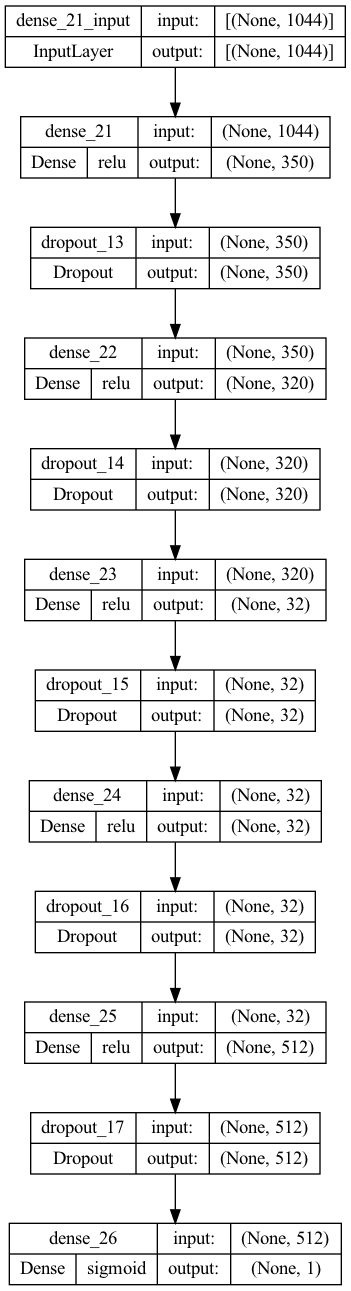

In [12]:
tf.keras.utils.plot_model(
model,
to_file=f"model_{model_for_testing}.png",
show_shapes=True,
show_dtype=False,
show_layer_names=True,
rankdir="TB",
expand_nested=True,
dpi=96,
layer_range=None,
show_layer_activations=True,
)

In [14]:
ypred = model.predict(X_test)

 19/243 [=>............................] - ETA: 0s 

2023-02-09 16:29:01.956701: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-09 16:29:02.021216: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


243/243 [==============================] - 1s 3ms/step


In [15]:
from numpy import argmax
# calculate roc curves
precision, recall, thresholds = precision_recall_curve(y_test, ypred)
# convert to f score
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))

Best Threshold=0.551734, F-Score=0.624


In [ ]:
# tn, fp, fn, tp
confusion_matrix(y_test, ypred > 0.7)

array([[6699,  213],
       [ 301,  563]])

In [16]:
thres = 0.55
print('F1 score: %.3f ' % f1_score(y_test, ypred > thres))
print('MCC: %.3f ' % matthews_corrcoef(y_test, ypred > thres))
print('Balanced accuracy: %.3f ' % balanced_accuracy_score(y_test, ypred > thres))
print('Precision : %.3f , Recall: %.3f ' % (precision_recall_fscore_support(y_test, ypred > thres, average='binary')[0], precision_recall_fscore_support(y_test, ypred > thres,  average='binary')[1]))

cm = confusion_matrix(y_test, ypred > thres)
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])
print(cm)

F1 score: 0.622 
MCC: 0.577 
Balanced accuracy: 0.781 
Accuracy: 0.919 
ROC : 0.899 
Precision : 0.643 , Recall: 0.603 
      0    1
0  6623  289
1   343  521
